In [388]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


**Importing libraries**

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization,\
RandomFlip , RandomRotation
from tensorflow.keras.utils import to_categorical
import datetime
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
print("TF version:", tf.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available!")

TF version: 2.6.4
GPU available (YESS!!!!)


**Unzip the training and test data and store them in  `tmp` folder**

In [19]:
path = '/kaggle/input/dogs-vs-cats-redux-kernels-edition'
train_unzip  = zipfile.ZipFile(path+'/train.zip', 'r')
test_unzip = zipfile.ZipFile(path+'/test.zip', 'r')
train_unzip.extractall('/tmp')
test_unzip.extractall('/tmp')
test_unzip.close()
train_unzip.close()

**confirm how many images are in the training set**

In [20]:
train_dir = '/tmp/train/'
print(f"There are {len(os.listdir(train_dir))} images of dogs and cats.")

There are 25000 images of dogs and cats.


**Store the paths in a list and assign labels to each image**

In [23]:
file_names = []
labels = []
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        filepath = subdir + file
        if filepath.endswith(".jpg"):
            file_names.append(filepath)
            if file[:3]=='dog':
                labels.append('dog')
            else:
                labels.append('cat')

In [24]:
unique_labels = np.unique(labels)
model_label = LabelEncoder().fit_transform(labels)
model_label = to_categorical(model_label)

**confirm we have the same number of labels and files**

In [25]:
print(f'There are {len(file_names)} file Paths')
print(f'There are {len(labels)} Labels') 

There are 25000 file Paths
There are 25000 Labels


**Create Functions to organize the pipeline of the model**

In [26]:
def process_image(IMAGE_PATH,IMG_SIZE = 240):
  """
  Takes an image file path and returns the tensor of the resized image 
  """
  image = tf.io.read_file(IMAGE_PATH) 
  # turn the jpg image into numerical tensors
  image = tf.image.decode_jpeg(image,channels=3) 
  # convert  the colour channel values from 0-255 to 0 -1 (normalization)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

In [27]:
def get_image_label(image_path,label):
  """
  Takes an image path with label 
  returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image , label

In [28]:
def process_data(X,y=None,val_data=False,test_data=False,augument=False,batch_size=32):
  """
  if val_data: returns a resized image and label tuple in the form of a tensor with the specified batch size.
  if test_data: returns a resized image in the form of a tensor with the specified batch size.
  if train_data: returns a resized and augumented image with labels tuple in the form of a tensor with the specified batch size.
  """
  AUTOTUNE = tf.data.AUTOTUNE
  # set up image augmentation 
  data_augmentation = Sequential([RandomFlip("horizontal_and_vertical"),RandomRotation(0.1)])

  if test_data: # no labels required
    print('creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data = data.map(process_image)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return data_batch
  
  if val_data: 
    print('creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return data_batch
  
  else:
    print('creating training data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    if augument:
        data = data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return data_batch

In [29]:
def show_images(images,labels,n=None,nrows=None,ncols=None):
  """ Displays a plot of n images and thier labels from a data batch """
  # set up the figure
  plt.figure(figsize=(10,10))
  #loop through
  for i in range(n):
    ax = plt.subplot(nrows,ncols,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[np.argmax(labels[i])])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [30]:
def save_model(model,suffix=None):
    """
    Saves a given model in a models directory and append a suffix (string)
    """
    modeldir = os.path.join('/models', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + '_' + '.h5'  #save format of a model
    model.save(model_path)
    
    return model_path

In [31]:
def load_model(model_path):
  """
  Loads a model from the specified path
  """
  print(f"Loading model from: {model_path}...")
  model = tf.keras.models.load_model(model_path)

  return model

In [32]:
def get_pred_label(prediction_prob):
  """
  Turns an array of prediction probabilities into a label 
  """
  return unique_labels[np.argmax(prediction_prob)]

In [34]:
def plot_pred(prediction_prob,labels,images, num=0,nrows=None,ncols=None):
  """
  View the prediction ground truth and images for sample n
  """
  # Create a Figure
  plt.figure(figsize=(5*ncols,3*nrows))
  for i in range(num):
      pred_prob , true_label , image = prediction_prob[i] , labels[i] , images[i]
      # get the pred label
      pred_label = get_pred_label(pred_prob)
      ax = plt.subplot(nrows,ncols,i+1)
      # change the color of the title depending on the prediction
      if pred_label == true_label:
        color = 'green' # True Prediction
      else:
        color = 'red' # Wrong Prediction
      # change plot title to be predicted class and probability
      plt.title((f"This image is {np.max(pred_prob)*100:2.0f}% {pred_label}"),
                color = color, fontweight='bold', fontsize=15)
      plt.imshow(image)
      plt.axis('off')
  plt.tight_layout()
  plt.show()

In [35]:
def unbatch_data(batch_data,test=False):
  """ Takes a bacthed dataset of (image,label) Tensors and returns separate arrays of """
  if test:  
      images = []
      for image in batch_data.unbatch().as_numpy_iterator():
        images.append(image)
      return images
  else:
      images = []
      labels = []
      for image , label in batch_data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_labels[np.argmax(label)])
      return images , labels

In [37]:
def model_diagnostic_plot(history,loss=False,accuracy=False):
    if loss:# plot loss
        plt.figure(figsize=(10,5))
        plt.subplot(211)
        plt.title('Training and validation Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
        plt.legend()
        plt.show()
    if accuracy: # plot accuracy
        plt.figure(figsize=(10,5))
        plt.subplot(212)
        plt.title('Training and validation Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.legend()
        plt.show()

**split the data into train and validation set**

In [38]:
X = file_names
y = model_label
X_train , X_val , Y_train , Y_val = train_test_split(X, y, random_state=42, test_size=0.15)

**create a train and validation batch**

In [40]:
train_data = process_data(X=X_train, y=Y_train,augument=True)
val_data = process_data(X=X_val, y=Y_val, val_data=True)

creating training data batches...
creating validation data batches...


**visualize a subject of the training data**

In [414]:
train_images , train_labels = next(train_data.as_numpy_iterator())

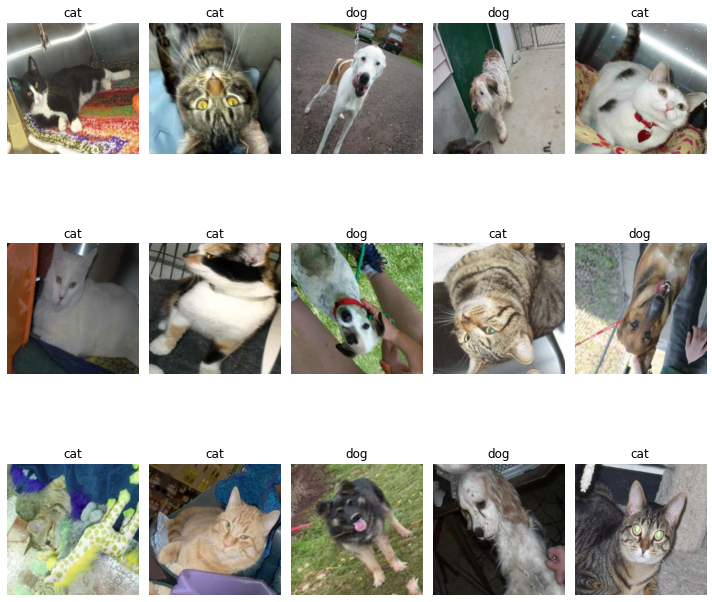

In [415]:
show_images(train_images[:15],train_labels[:15],n=15,nrows=3,ncols=5)

**Setup the network**

In [416]:
def make_model(image=IMG_SIZE,input=INPUT_SHAPE,output=OUTPUT_SHAPE):

    model = Sequential()
    model.add(Input(shape= INPUT_SHAPE,name ='input'))
    model.add(Conv2D(filters=32,kernel_size=[5,5],activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64,kernel_size=[5,5],activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.4))
    
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(OUTPUT_SHAPE,activation='sigmoid'))
    
    return model

In [417]:
IMG_SIZE = 240
INPUT_SHAPE = (IMG_SIZE,IMG_SIZE,3)
OUTPUT_SHAPE = len(unique_labels)
model = make_model(IMG_SIZE,INPUT_SHAPE,OUTPUT_SHAPE)
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 236, 236, 32)      2432      
_________________________________________________________________
batch_normalization_36 (Batc (None, 236, 236, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 114, 114, 64)      51264     
_________________________________________________________________
batch_normalization_37 (Batc (None, 114, 114, 64)      256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 57, 57, 64)      

In [421]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create a Tensorboard session
# tensorbaord = create_tensorboard_callback()
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
# fit the model to the data and pass it the callbacks
batch_size = 32
history = model.fit(x=train_data,validation_data=val_data, epochs=20) #callbacks = [tensorbaord,early_stopping]

Epoch 1/20
665/665 [==============================] - 161s 241ms/step - loss: 0.6048 - accuracy: 0.6712 - val_loss: 0.5729 - val_accuracy: 0.6877
Epoch 2/20
665/665 [==============================] - 160s 240ms/step - loss: 0.5728 - accuracy: 0.7029 - val_loss: 0.5728 - val_accuracy: 0.6944
Epoch 3/20
665/665 [==============================] - 159s 240ms/step - loss: 0.5413 - accuracy: 0.7245 - val_loss: 0.5775 - val_accuracy: 0.6917
Epoch 4/20
665/665 [==============================] - 160s 240ms/step - loss: 0.5216 - accuracy: 0.7411 - val_loss: 0.5838 - val_accuracy: 0.7085
Epoch 5/20
665/665 [==============================] - 160s 240ms/step - loss: 0.5013 - accuracy: 0.7568 - val_loss: 0.6686 - val_accuracy: 0.6384
Epoch 6/20
665/665 [==============================] - 159s 239ms/step - loss: 0.4931 - accuracy: 0.7619 - val_loss: 0.5020 - val_accuracy: 0.7597
Epoch 7/20
665/665 [==============================] - 159s 239ms/step - loss: 0.4748 - accuracy: 0.7724 - val_loss: 0.5777 -

In [423]:
# save model
save_path = save_model(model)

In [41]:
# load model
loaded_model = load_model('/models/20230103-185025_.h5')

Loading model from: /models/20230103-185025_.h5...


**model diagnostics plot**

In [51]:
# model_diagnostic_plot(loaded_model,loss=True, accuracy=True)

**loading the test data**

In [52]:
test_path = '/tmp/test/'
test_dir = []
for subdir, dirs, files in os.walk(test_path):
    for file in files:
        filepath = subdir + file
        if filepath.endswith(".jpg"):
            test_dir.append(filepath)

**processing the test data with the process_data function**

In [53]:
test_data = process_data(X=test_dir, test_data=True)

creating test data batches...


**making predictions on the test data**

In [54]:
pred_prob = loaded_model.predict(test_data)

2023-01-03 19:07:58.248869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-03 19:08:00.385199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


**unbatch test data**

In [1]:
 pred_images = unbatch_data(test_data,test=True)

NameError: name 'unbatch_data' is not defined

**plot the predicted image and the probability of model on test data**

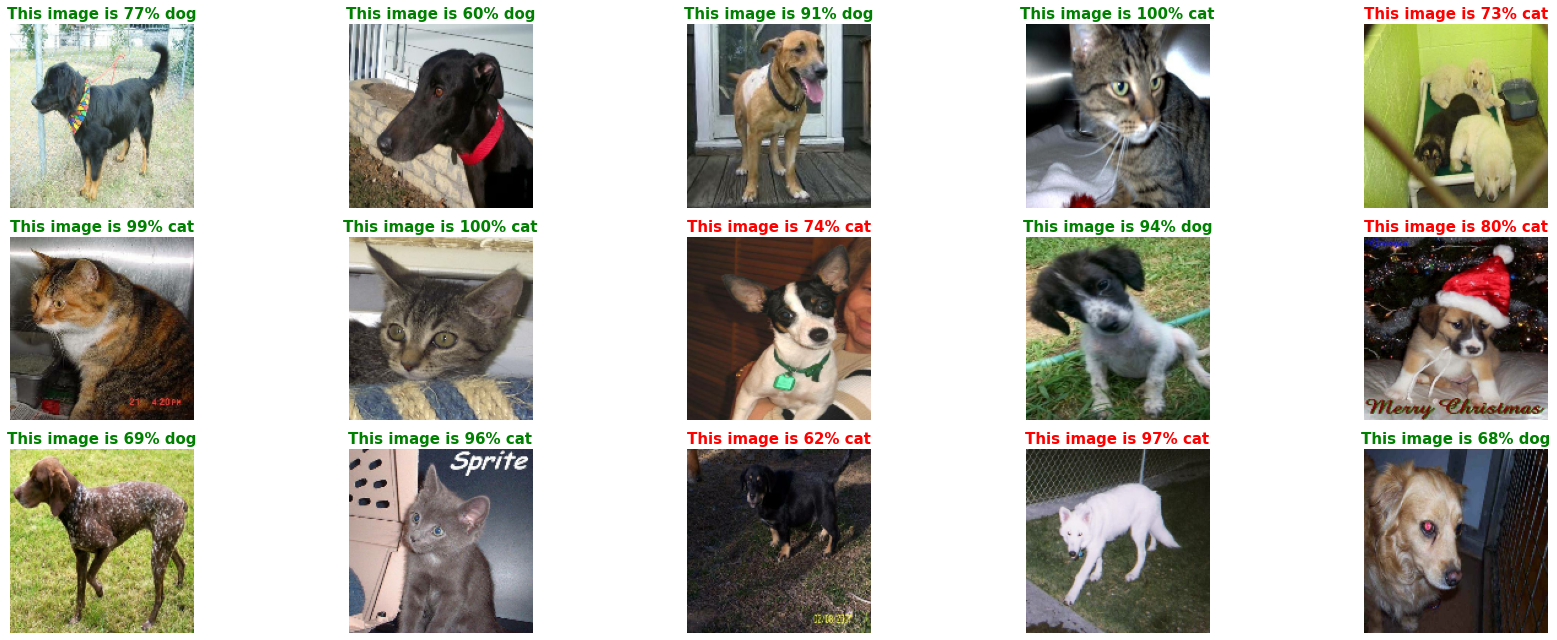

In [305]:
plot_pred(pred_prob,pred_labels,pred_images,num=15,nrows=3,ncols=5)

**Submission**

In [ ]:
# unique_labels = {'cats': 0, 'dogs': 1}
df = pd.DataFrame()
df['Filename'] = test_dir.split()
df['category'] = np.where(predict > threshold, 1,0)

**TensorBoard and early stopping callback to track models progress**


In [ ]:
def create_tensorboard_callback():
  # create a log directory for storing tensorboard logs
  logdir = os.path.join('logs/',
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)